In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        
        self.actor = nn.Sequential(
                
                            nn.Linear(state_dim,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,action_dim),
                            
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                            nn.Linear(state_dim,128),
                            nn.ReLU(),
                            nn.Linear(128,64),
                            nn.ReLU(),
                            nn.Linear(64,1)
                    )
        
    def forward(self,state):
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
            return dist


In [11]:
def gen_param_array(l16_array):
    full = []
    for row in range(len(l16_array)):
        x = l16_array[row]
        arr_params = []
        
        for col in range(len(x)):
            list_params = list(params.values())[col]
            value = list_params[x[col]]
            arr_params.append(value)
        print(arr_params)
        full.append(arr_params)
    return full

In [12]:
def IQR(arr):
    # First quartile (Q1)
    Q1 = np.percentile(arr, 25, interpolation = 'midpoint')

    # Third quartile (Q3)
    Q3 = np.percentile(arr, 75, interpolation = 'midpoint')

    # Interquaritle range (IQR)
    IQR = Q3 - Q1
    return IQR

# Detrending

In [6]:
def differencing(dataset,interval):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [7]:
for i in range(16):
    arr = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(arr)
    moving_ave = df.iloc[1:,1].rolling(50,min_periods=1).mean().values.flatten().tolist()
    diff = differencing(moving_ave,1)
    IQR_val = IQR(diff)
    print(f"Detrended Trial {i} IQR: {IQR_val}")
    x = np.array([i for i in range(len(diff))])
    fig = plt.figure(figsize = (10,10))
    plt.ylim((-1.5e3,1.5e3))
    plt.title(f"Trial {i}, IQR: {IQR_val}")
    plt.plot(x,diff)

NameError: name 'IQR' is not defined

In [ ]:
df_collate_detrend = pd.DataFrame([])
print("Run 1: During Learning Detrended Standard Deviations")
for i in range(len(params_array)):
    arr = params_array[i]
    
    arr_r = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(arr_r)
    moving_ave = df.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    diff = differencing(moving_ave,1)
    
    df_interest = pd.DataFrame(diff)
    df_collate_detrend = pd.concat([df_collate_detrend, df_interest], axis=1)
    
    print(f"Treatment {i}: Variance = {np.std(diff)}")


# Visualise All Plots

In [8]:
l16_array = np.array(pd.read_csv('L16.txt',header=None, sep='\t'))

In [9]:
params = { 'eps_clipping' : [2e-05,2e-04,2e-03,2e-02],
            'gamma' : [0.8,0.9,0.95,0.99],
            'actor_lr' : [1e-04,5e-03,1e-03,1e-02],
            'critic_lr' : [1e-04,5e-03,1e-03,1e-02]}

In [13]:
params_array = gen_param_array(l16_array)

[2e-05, 0.8, 0.0001, 0.0001]
[2e-05, 0.9, 0.005, 0.005]
[2e-05, 0.95, 0.001, 0.001]
[2e-05, 0.99, 0.01, 0.01]
[0.0002, 0.8, 0.005, 0.001]
[0.0002, 0.9, 0.0001, 0.01]
[0.0002, 0.95, 0.01, 0.0001]
[0.0002, 0.99, 0.001, 0.005]
[0.002, 0.8, 0.001, 0.01]
[0.002, 0.9, 0.01, 0.001]
[0.002, 0.95, 0.0001, 0.005]
[0.002, 0.99, 0.005, 0.0001]
[0.02, 0.8, 0.01, 0.005]
[0.02, 0.9, 0.001, 0.0001]
[0.02, 0.95, 0.005, 0.01]
[0.02, 0.99, 0.0001, 0.001]


In [38]:
params_df = pd.DataFrame(params_array, columns = ['eps_clipping','gamma','actor_lr','critic_lr'])
params_df.to_csv('params.csv')

In [ ]:
for i in range(len(params_array)):
    arr = params_array[i]
    fig = plt.figure(figsize=(7,7))
    plt.title(f"During Learning: Trial {i}, eps_clipping: {arr[0]}, Gamma: {arr[1]}, actor_lr: {arr[2]}, critic_lr: {arr[3]}")
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    moving_ave = df.iloc[1:,1].rolling(50,min_periods=1).mean().values.flatten().tolist()
    
    data_eval = np.loadtxt(f"run_1/eval_trial_{i}.txt",delimiter=",")
#     df_eval = pd.DataFrame(data_eval)
#     eval_moving_ave = df_eval.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    
    plt.plot(data[1:,0],data[1:,1])
    plt.plot(data[1:,0],moving_ave,label = "Moving Ave: 50")
    #plt.plot(data_eval[1:,1],eval_moving_ave,label="Eval Moving Ave: 50")
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Average reward')

# BoxPlot

In [ ]:
df_collate = pd.DataFrame([])
for i in range(len(params_array)):
    arr = params_array[i]
    #fig = plt.figure(figsize=(10,10))
    #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    df_interest = df.iloc[:,1]
    df_collate = pd.concat([df_collate, df_interest], axis=1)
    

In [ ]:
df_collate.columns = [f"Trial {x}" for x in range(16)]

In [ ]:
df_collate = df_collate.drop(0)
df_collate

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: During Training Boxplot",fontsize = 20)
ax = df_collate.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: During Training Boxplot",fontsize = 20)
ax = df_collate.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

# Mean & Standard Dev

During Learning

In [ ]:
variance_weight = 1
for i in range(len(params_array)):
    arr = params_array[i]
    
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(data)
    moving_ave = np.array(df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten())
    Mean = round(np.mean(moving_ave),2)
    Std = round(np.std(moving_ave),2)
    iqr = round(IQR(moving_ave),2)
    Mean_last_n = np.mean(df.iloc[-100:,0])
    
    print(f"Total Trial {i}, Mean: {Mean}, Std Dev: {Std}, Mean last 100: {Mean_last_n} SNR: {Mean/(variance_weight*Std)}, IQR: {iqr}")
#     for j in range(3):
#         Mean_third = round(np.mean(moving_ave[1000*j:1000*(j+1)]),2)
#         Std_third = round(np.std(moving_ave[1000*j:1000*(j+1)]),2)
#         iqr_third = round(IQR(moving_ave[1000*j:1000*(j+1)]),2)
#         print(f"Quatile {j+1} Trial {i}, Mean: {Mean_third}, Std Dev: {Std_third}, SNR: {Mean_third/(variance_weight*Std_third)}, IQR: {iqr_third}")
    
    print()

In [ ]:
def gradient(arr,window):
    gradient_arr = []
   
    for i in range(len(arr)):
        if i < window:
            continue
          
        y = arr[i-window:i+1,0]
        x = arr[i-window:i+1,1]
        grad, b = np. polyfit(x, y, 1)
        gradient_arr.append([grad,b])
    return gradient_arr

In [ ]:
gradient(test_2,100)[1400:]

# After Learning Evaluation

In [49]:
from machine import Machine
from GymMachEnv import MachineEnv

In [50]:
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        state = torch.Tensor(environment.reset())
        state = state.unsqueeze(0)
        episode_return = 0.0 
        while not environment.done:
            action = policy(state).sample()
            next_state, reward, done, _ = environment.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            state = next_state
            episode_return += reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return# Evaluate the agent's policy once before training.

In [51]:
def evaluate(env,agent):
    episodic_rewards = []
    trials = 500
    
    
    for t in range(trials):
        episodic_rewards.append(compute_avg_return(env,agent,20))
        #print(episodic_rewards[-1])
        
    return np.array(episodic_rewards)


In [62]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)


C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [2]:
runs = ['eval_1','eval_2','eval_3']


# for x in runs:
#     for i in range(16):
#         model = torch.load(f'run_1/trial_{i}_ppo_agent.pt')
#         parameters = params_array[i]
#         result = evaluate(env,model)
#         np.savetxt(f'run_1/{x}/evaluated_trial_{i}.txt', result, delimiter=',',fmt='%s')
    

In [64]:
model = torch.load(f'default/trial_0_ppo_agent.pt')
result = evaluate(env,model)
np.savetxt('default/evaluated_trial_0.txt', result, delimiter=',',fmt='%s')

# Processing of data

In [5]:
runs = ['eval_1','eval_2','eval_3']
df_total = pd.DataFrame()

for x in runs:
    mean_arr = []
    for i in range(16):
        mean_arr.append(np.mean(np.loadtxt(f'run_1/{x}/evaluated_trial_{i}.txt')))
    df= pd.DataFrame(mean_arr)
    df_total= pd.concat([df_total,df],axis=1)

df_total.columns = runs
df_total['average'] = df_total.mean(axis=1)
df_total.to_csv('Eval_mean.csv')


In [15]:
np.mean(np.loadtxt('run_1/eval_1/evaluated_trial_0.txt'))

21540.42

# Visualise After Learning Plots

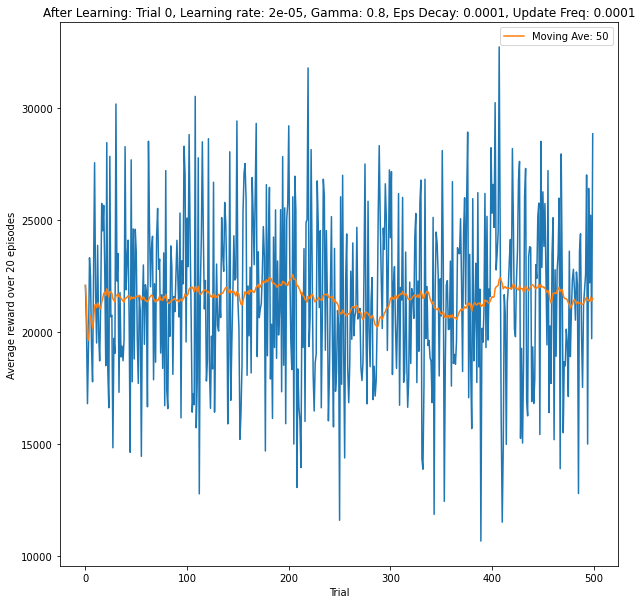

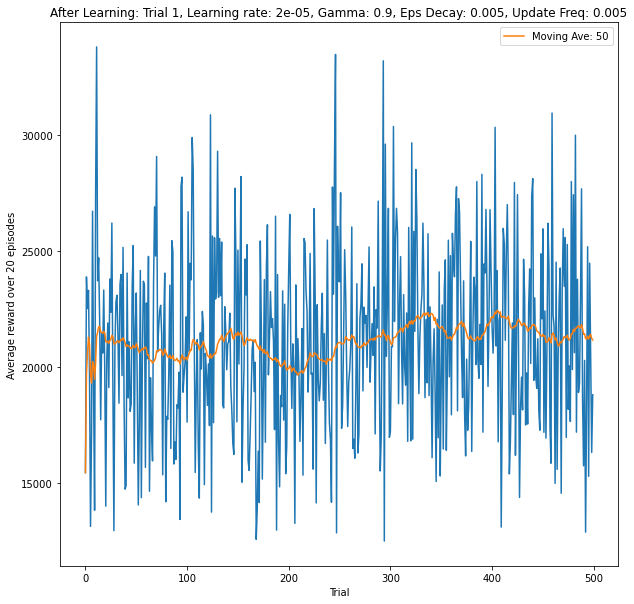

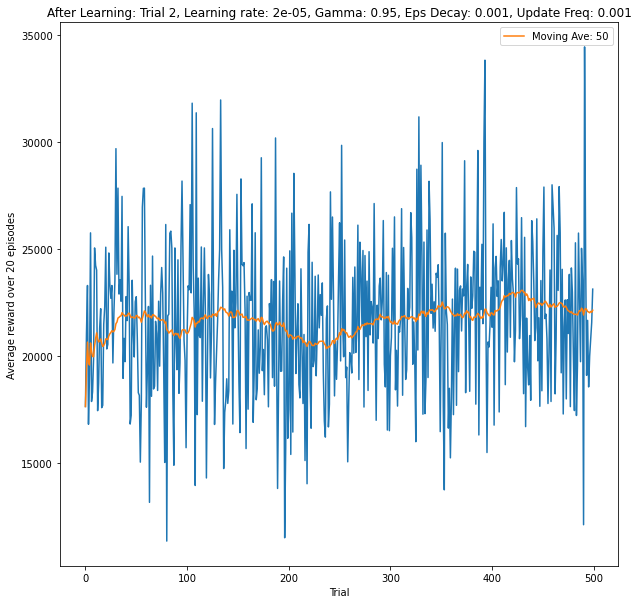

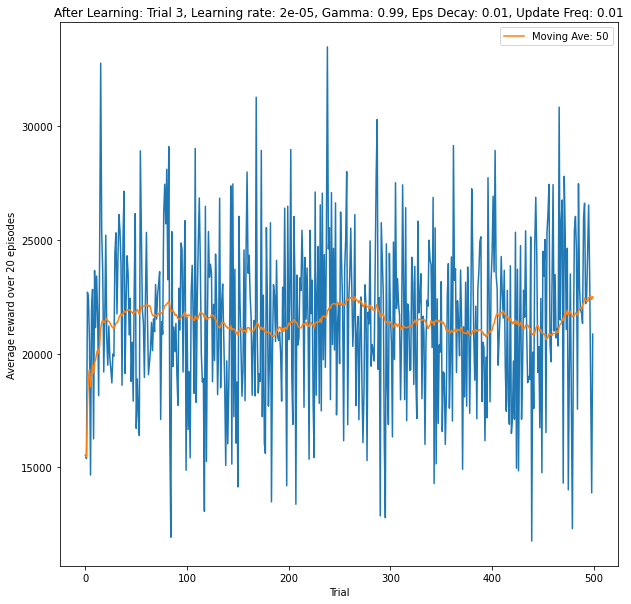

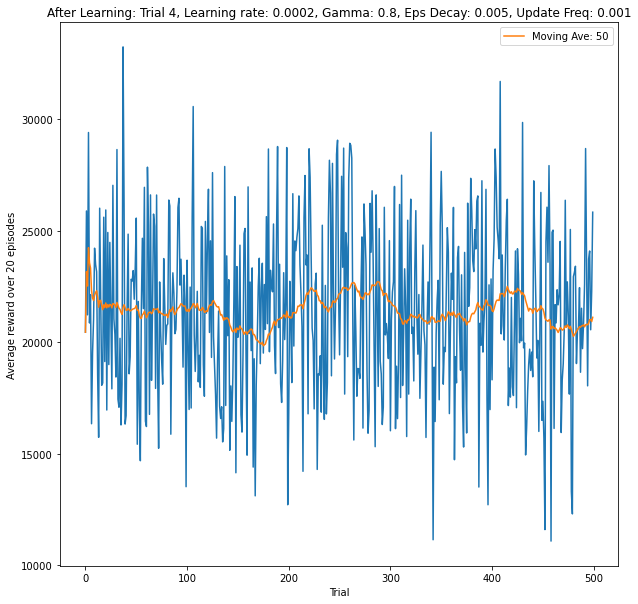

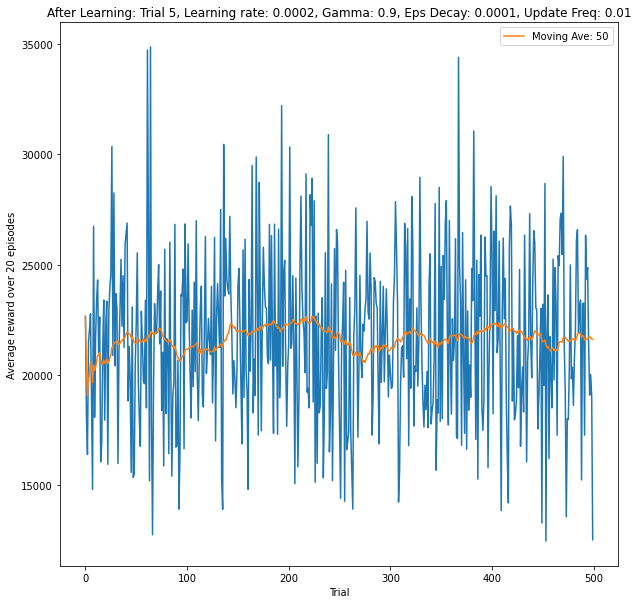

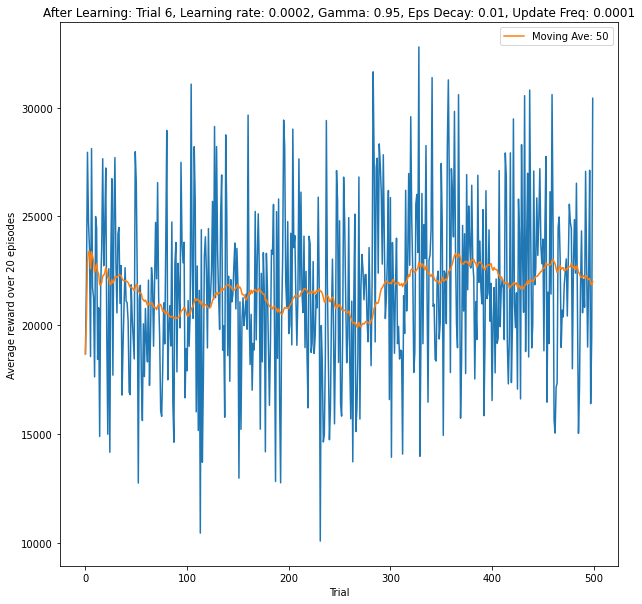

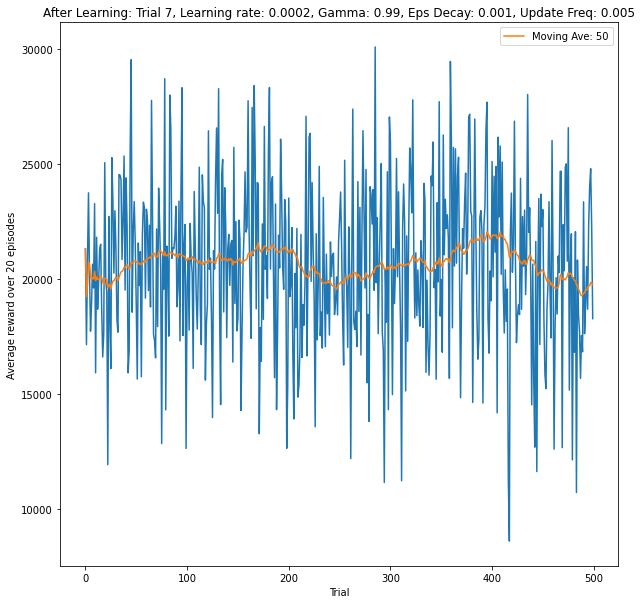

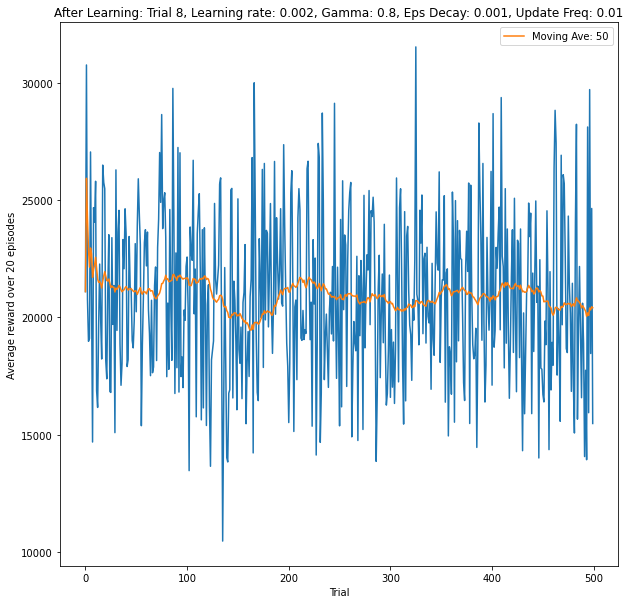

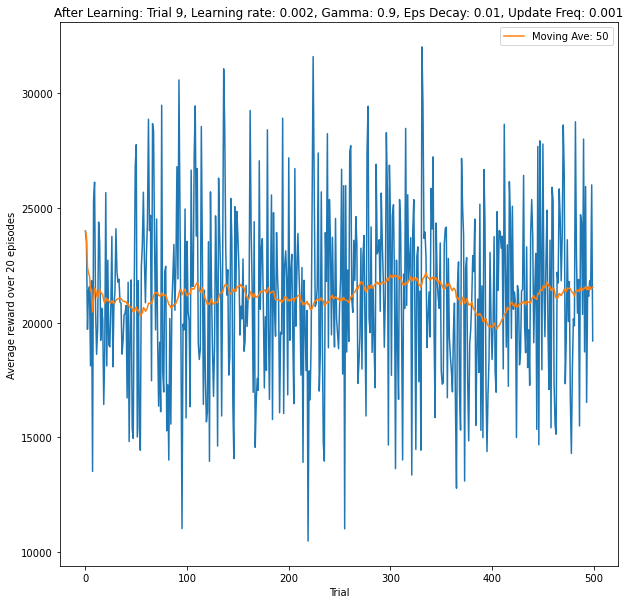

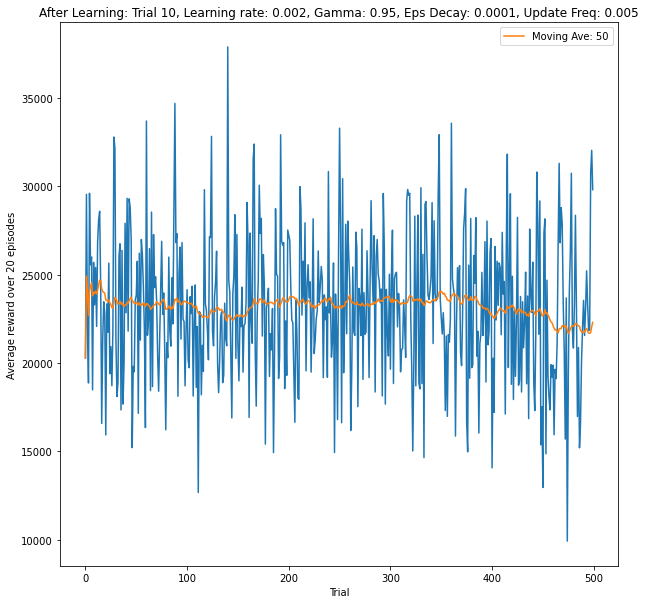

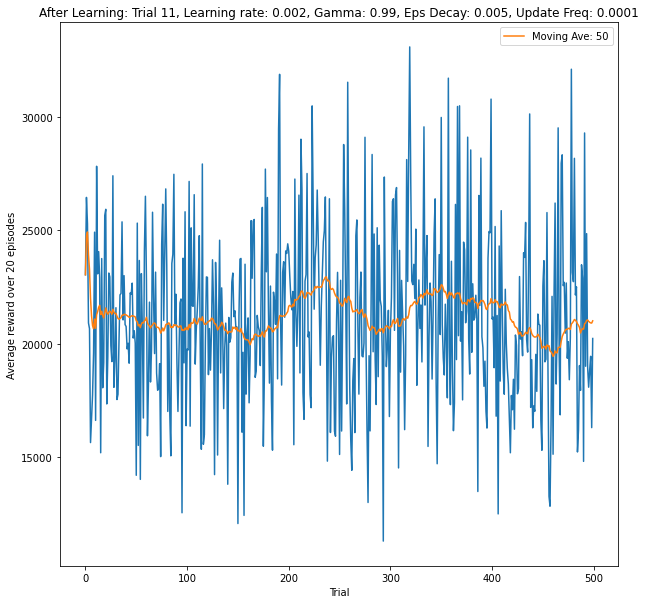

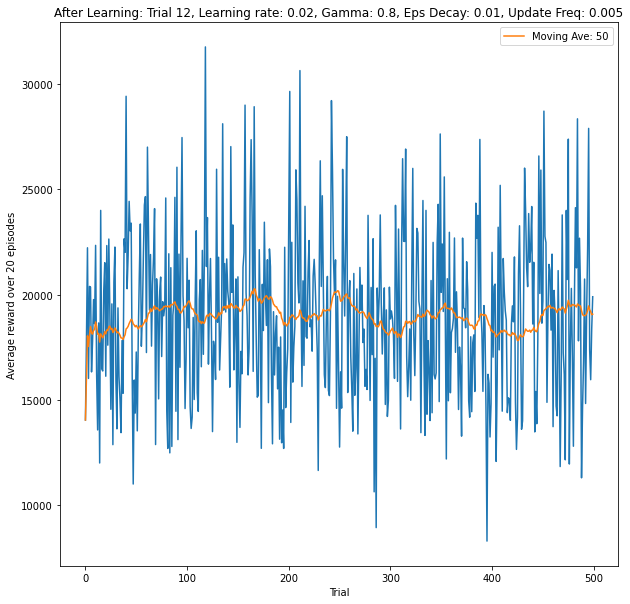

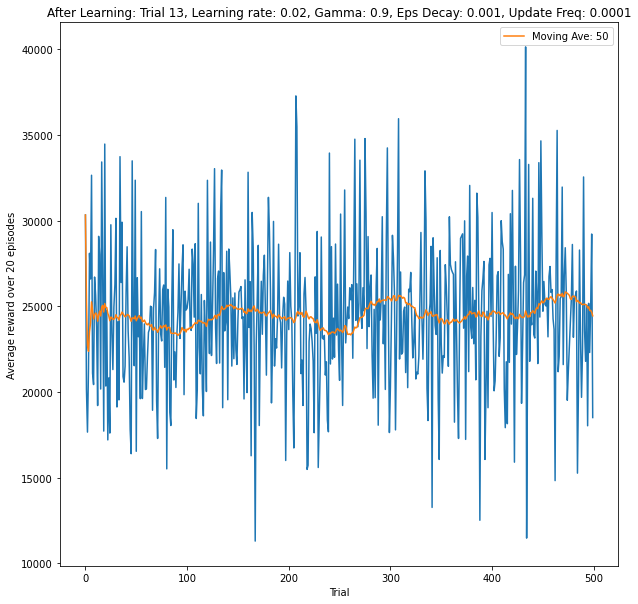

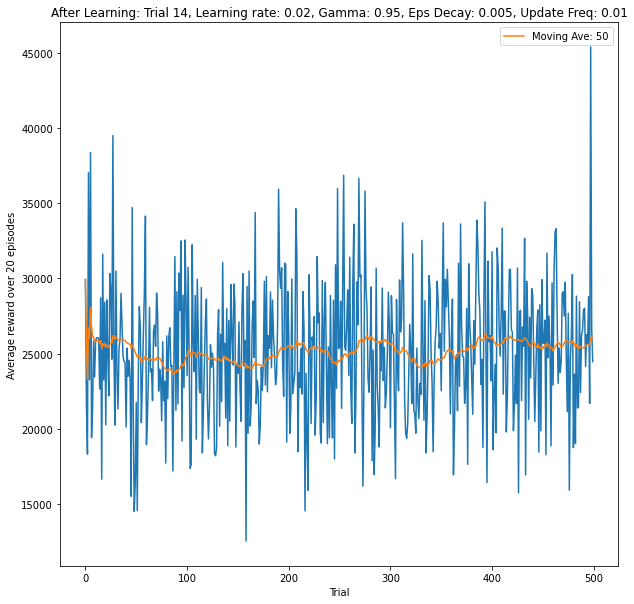

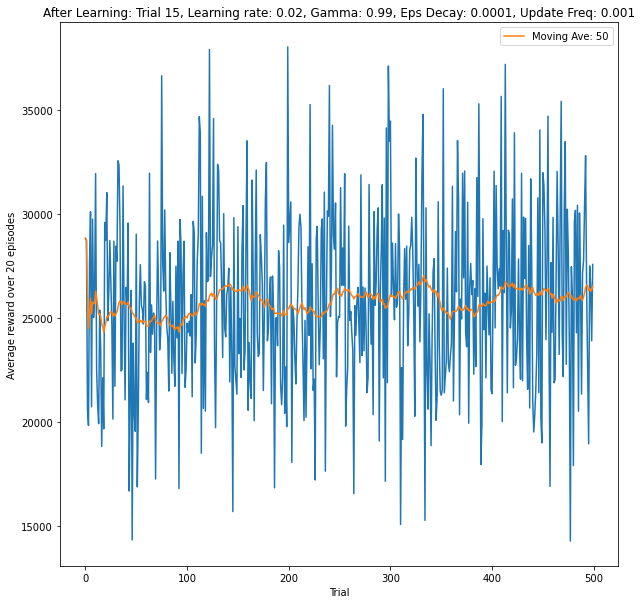

In [9]:
for i in range(len(params_array)):
    arr = params_array[i]
    
    data = np.loadtxt(f"run_1/eval_1/evaluated_trial_{i}.txt")
    df = pd.DataFrame(data)
    ep = [x for x in range(len(data))]
    moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
    
    fig = plt.figure(figsize=(10,10))
    plt.title(f"After Learning: Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    plt.plot(ep,data)
    plt.plot(ep,moving_ave,label = "Moving Ave: 50")
    plt.legend()
    plt.xlabel('Trial')
    plt.ylabel('Average reward over 20 episodes')
    plt.show()

Average

In [ ]:
dict_run = {i:[] for i in range(16)}
runs = ['eval_1','eval_2','eval_3']
weight_var = 1
for eval in runs:
    print(eval)
    for i in range(len(params_array)):
        arr = params_array[i]
        data = np.loadtxt(f"run_1/{eval}/evaluated_trial_{i}.txt")
        mean = np.mean(data)
        dict_run[i].append(mean)
        
        std = np.std(data)
        median = np.median(data)
        IQR_ = IQR(data)
        if mean < 10000: continue
        print(f"Trial {i}, Mean: {round(mean,2)}, Std: {round(std,2)}, SNR: {round(mean/(weight_var*std),2)}, Median: {round(median,2)}, IQR: {round(IQR_,2)}, Median/IQR: {round(median/(weight_var*IQR_),2)}")
    print()
    
for key, value in dict_run.items():
    arr_np=np.array(value)
    print(f"Average Mean for Trial {key}: {np.mean(arr_np)}")

<Figure size 720x720 with 0 Axes>

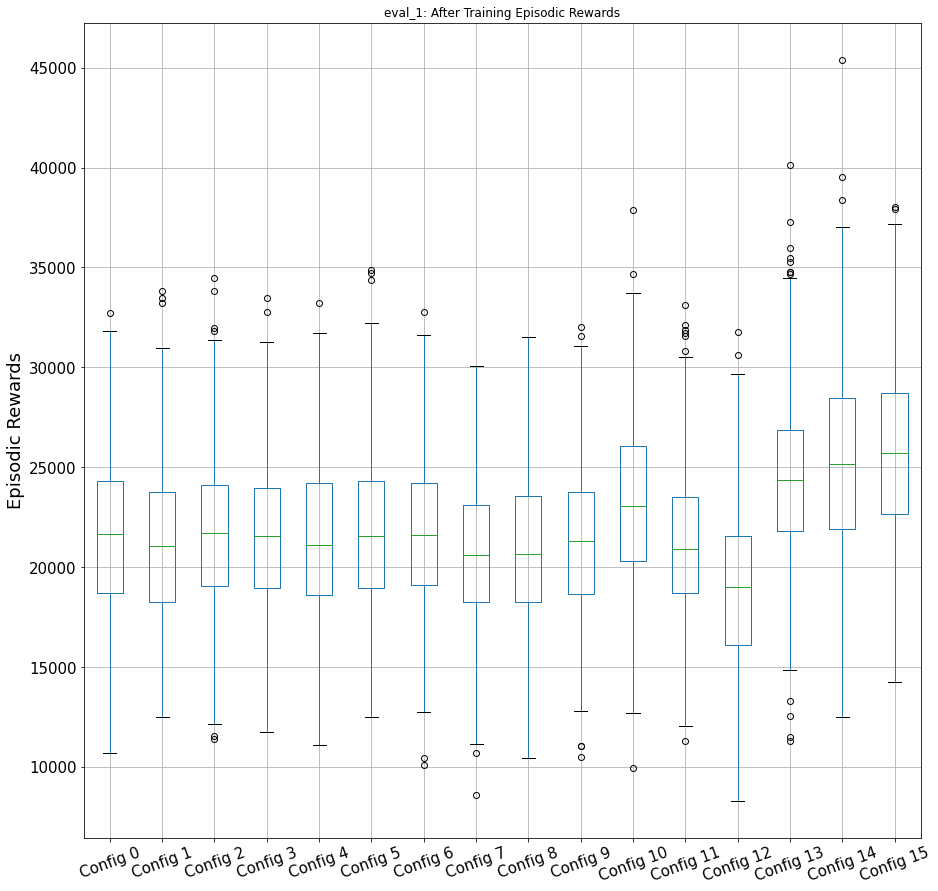

<Figure size 720x720 with 0 Axes>

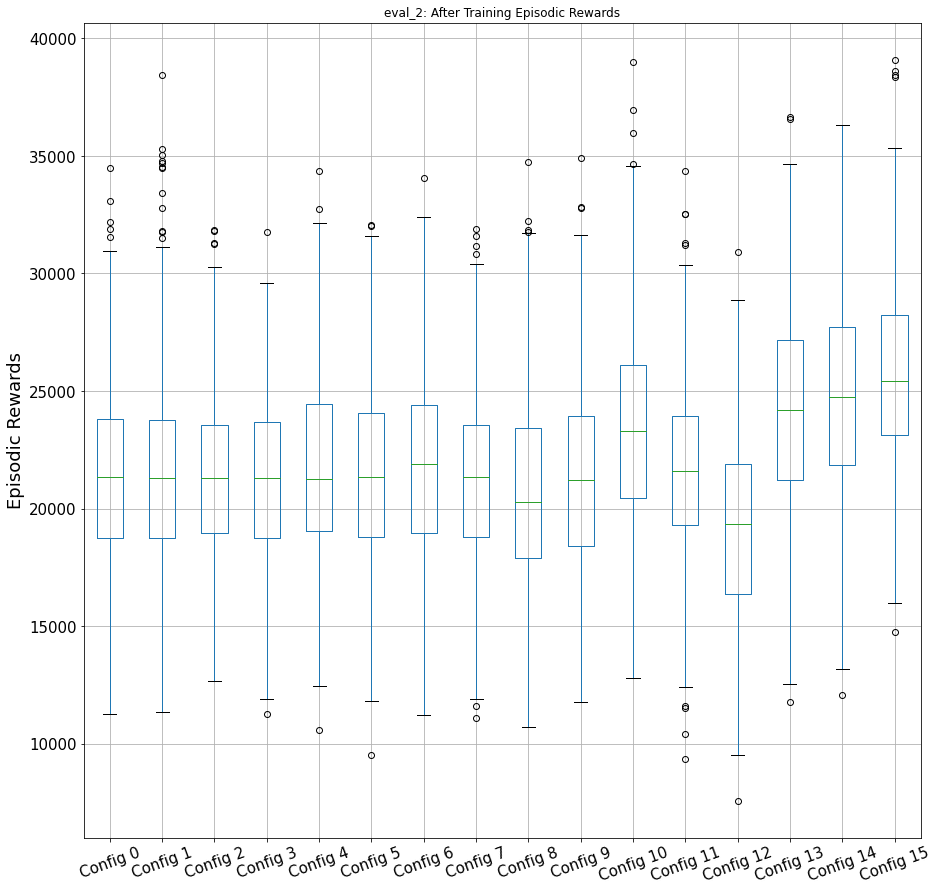

<Figure size 720x720 with 0 Axes>

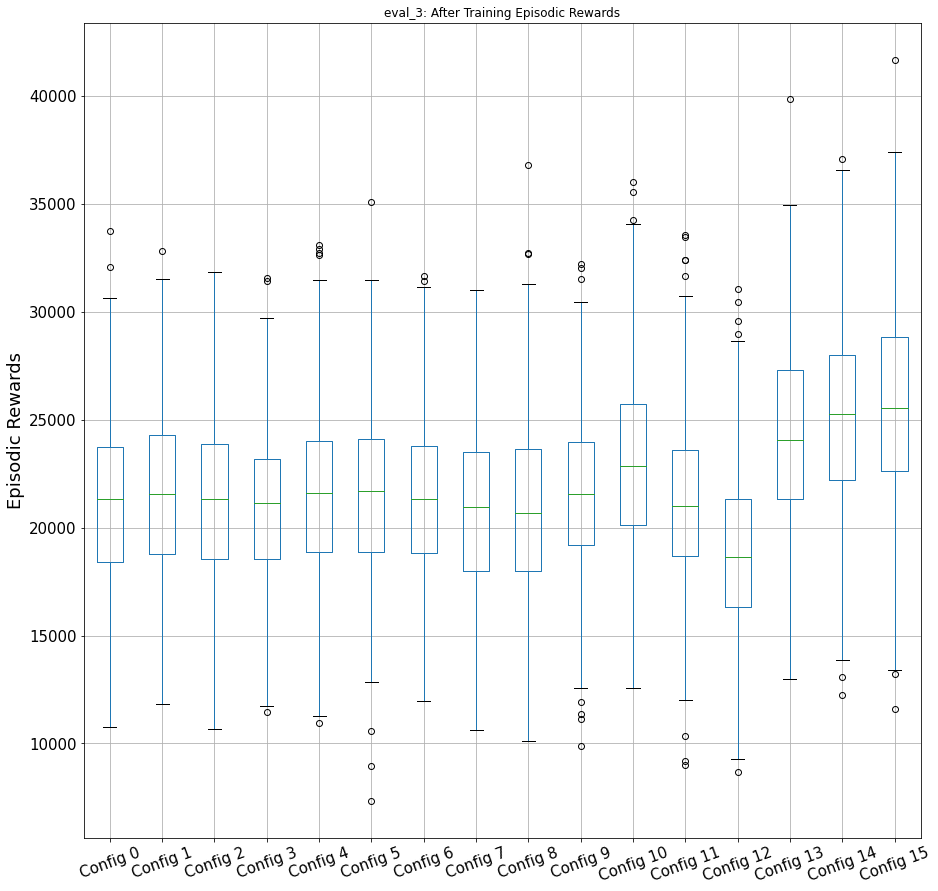

In [14]:
for x in runs:
    df_collate_all = pd.DataFrame([])
    fig = plt.figure(figsize=(10,10))
    for i in range(len(params_array)):
        arr = params_array[i]
        #fig = plt.figure(figsize=(10,10))
        #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
        data = np.loadtxt(f"run_1/{x}/evaluated_trial_{i}.txt")
        df = pd.DataFrame(data)
        df_collate_all = pd.concat([df_collate_all, df], axis=1)
    
    
    df_collate_all.columns = [f"Config {x}" for x in range(16)]
    fig = plt.figure(figsize=(15,15))
    plt.title("Run 1: During Training Boxplot",fontsize = 20)
    ax = df_collate_all.boxplot(grid=True, rot=20, fontsize=15)
    plt.title(f'{x}: After Training Episodic Rewards')
    plt.ylabel('Episodic Rewards',fontsize=18)
    plt.show()

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

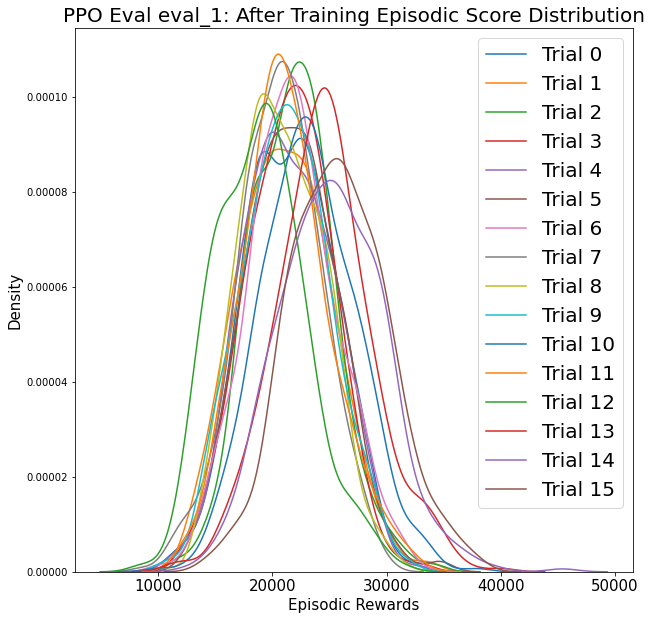

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

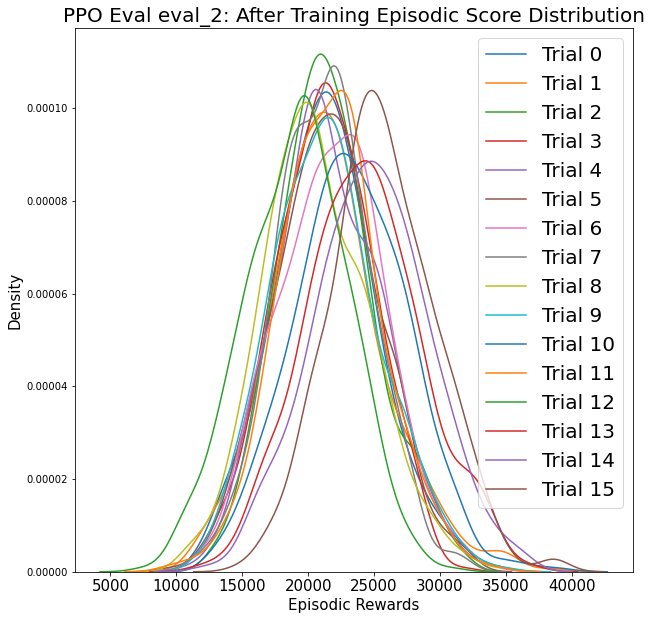

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

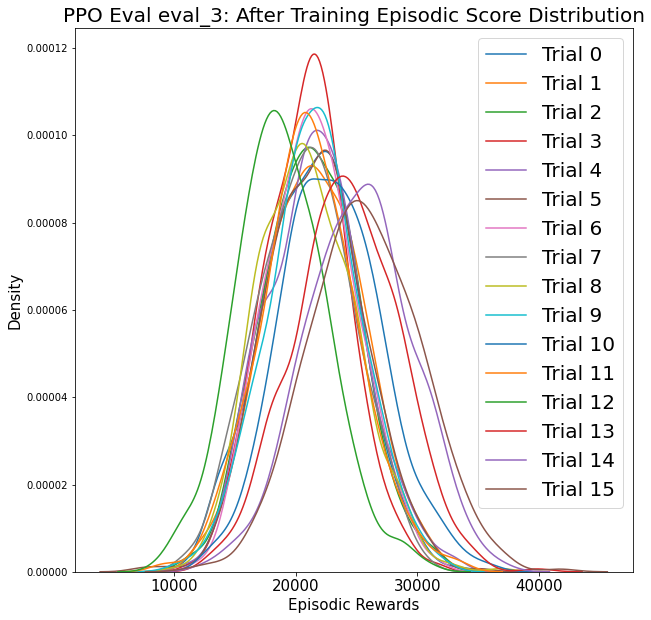

In [65]:
import seaborn as sns


for x in runs:
    fig = plt.figure(figsize=(10,10))
    for i in range(len(params_array)):
        arr = params_array[i]
        #fig = plt.figure(figsize=(10,10))
        #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
        data = np.loadtxt(f"run_1/{x}/evaluated_trial_{i}.txt")

        df_interest = pd.DataFrame(data)
        ax = sns.distplot(df_interest,hist=False,label=f"Trial {i}")
    plt.legend(prop={'size': 20})
    plt.title(f"PPO Eval {x}: After Training Episodic Score Distribution",fontsize=20)
    plt.xlabel("Episodic Rewards",fontsize=15)
    plt.ylabel("Density",fontsize=15)
    plt.xticks(fontsize= 15)
    plt.show()


Moving Average

In [ ]:
runs = ['eval_1','eval_2','eval_3']
weight_var = 1
for eval in runs:
    print(eval)
    for i in range(len(params_array)):
        arr = params_array[i]
        data = np.loadtxt(f"run_1/{eval}/evaluated_trial_{i}.txt")
        df = pd.DataFrame(data)
        moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
        mean = np.mean(moving_ave)
        std = np.std(moving_ave)
        median = np.median(moving_ave)
        IQR_ = IQR(moving_ave)
        if mean < 10000: continue
        print(f"Trial {i}, Mean: {round(mean,2)}, Std: {round(std,2)}, SNR: {round(mean/(weight_var*std),2)}, Median: {round(median,2)}, IQR: {round(IQR_,2)}, Median/IQR: {round(median/(weight_var*IQR_),2)}")
    print()

In [ ]:
df_collate_fp = pd.DataFrame([])
for i in range(len(params_array)):
    arr = params_array[i]
    #fig = plt.figure(figsize=(10,10))
    #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/eval_1/evaluated_trial_{i}.txt")
    
    df_interest = pd.DataFrame(data)
    df_collate_fp = pd.concat([df_collate_fp, df_interest], axis=1)

In [ ]:
df_collate_fp.columns = [f"Trial {x}" for x in range(16)]


In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: After Training Boxplot",fontsize = 20)
ax = df_collate_fp.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

# Check Best

In [55]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

model = torch.load('best/trial_1_ppo_agent.pt')
model.eval()

arr = evaluate(env,model)
np.savetxt(f'best/evaluated_trial_1.txt', arr, delimiter=',',fmt='%s')

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


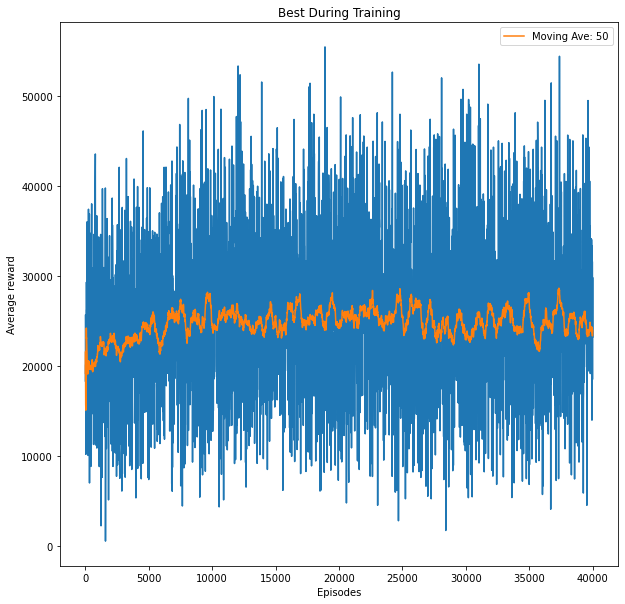

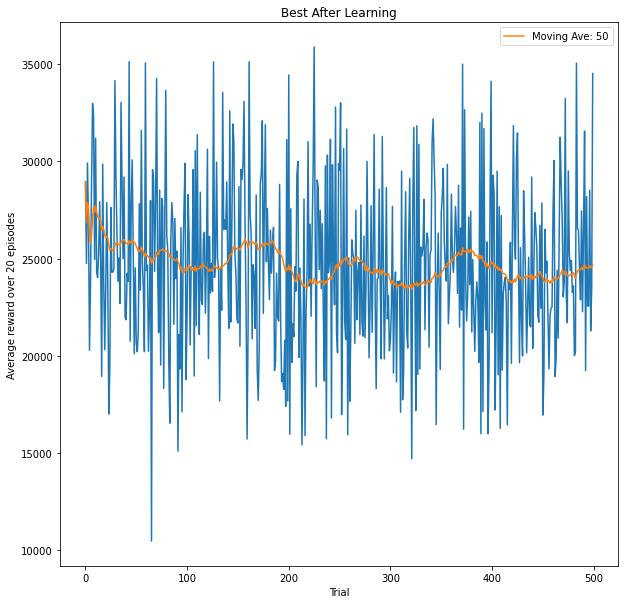

In [72]:
data = np.array(pd.read_csv('best/eval_trial_0.txt',header=None))

df = pd.read_csv('best/eval_trial_1.txt',header=None)
moving_ave = df.iloc[1:,1].rolling(50,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(data[1:,0],data[1:,1])
plt.plot(data[1:,0],moving_ave,label = "Moving Ave: 50")
#plt.plot(data_eval[1:,1],eval_moving_ave,label="Eval Moving Ave: 50")
plt.title('Best During Training')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()



data = np.loadtxt(f"best/evaluated_trial_1.txt")
df_best = pd.DataFrame(data)
ep = [x for x in range(len(data))]
moving_ave = np.array(df_best.rolling(50,min_periods=1).mean().values.flatten())
fig = plt.figure(figsize=(10,10))
plt.title(f"Best After Learning")
plt.plot(ep,data)
plt.plot(ep,moving_ave,label = "Moving Ave: 50")
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Average reward over 20 episodes')
plt.show()


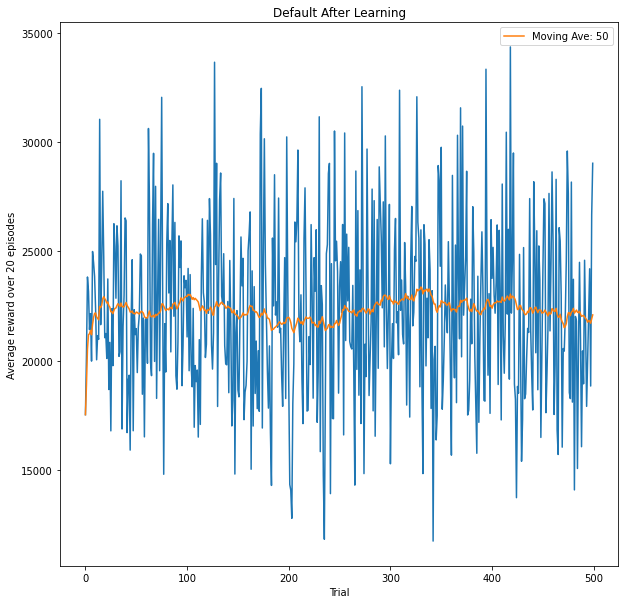

In [79]:
data = np.loadtxt(f"default/evaluated_trial_0.txt")
df_default = pd.DataFrame(data)
ep = [x for x in range(len(data))]
moving_ave = np.array(df_default.rolling(50,min_periods=1).mean().values.flatten())
fig = plt.figure(figsize=(10,10))
plt.title(f"Default After Learning")
plt.plot(ep,data)
plt.plot(ep,moving_ave,label = "Moving Ave: 50")
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Average reward over 20 episodes')
plt.show()

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


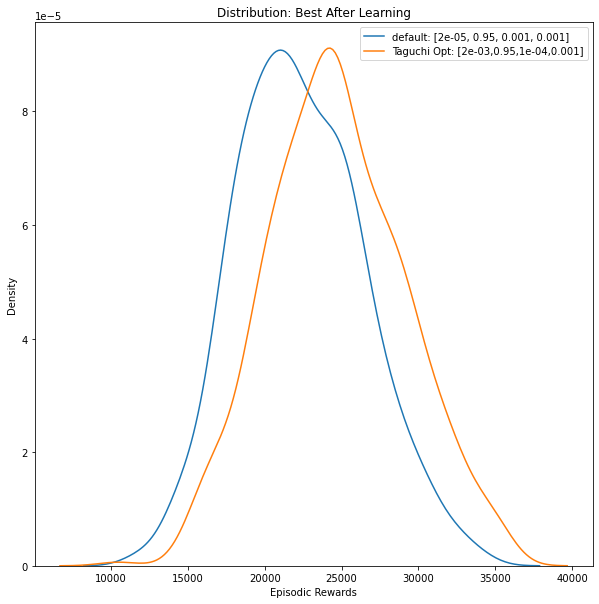

In [78]:
fig = plt.figure(figsize=(10,10))
plt.title(f"Distribution: Best After Learning")
ax = sns.distplot(df_default,hist=False,label='default: [2e-05, 0.95, 0.001, 0.001]')
ax = sns.distplot(df_best,hist=False,label='Taguchi Opt: [2e-03,0.95,1e-04,0.001]')
plt.xlabel('Episodic Rewards')
plt.legend()
plt.show()

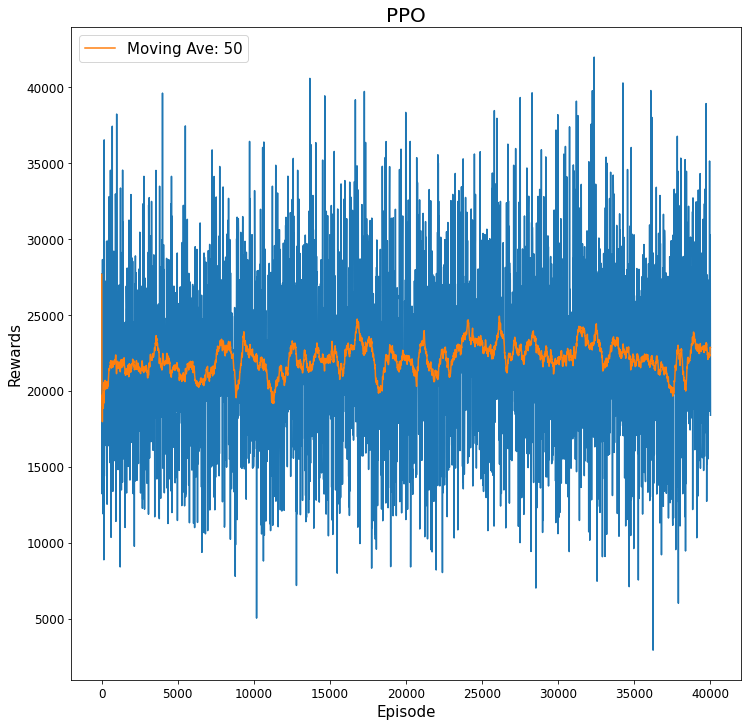

In [9]:
data = np.loadtxt('default/trial_0.txt',delimiter = ',')
fig = plt.figure(figsize = (12,12))
df = pd.DataFrame(data)
moving_ave = df.iloc[:,1].rolling(50,min_periods=1).mean().values.flatten().tolist()
plt.plot(data[:,0],data[:,1])
plt.plot(data[:,0],moving_ave,label = "Moving Ave: 50")
plt.legend(fontsize = 15)
plt.xlabel('Episode',fontsize = 15)
plt.ylabel('Rewards',fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('PPO', fontsize = 20)
plt.show()